### Acetic Acid Test

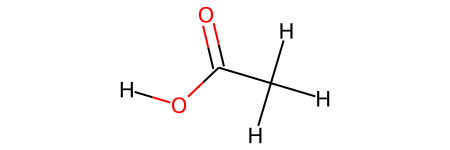

In [1]:
from rdkit import Chem

# Create test molecule of acetic acid
acetic_acid = 'CC(O)=O'

temp = Chem.MolFromSmiles(acetic_acid)
mol = Chem.AddHs(temp)
mol

In [2]:
# Define the node and edge features to be used
ATOM_FEATURES = {
    'atomic_num': [1, 6, 8]
}
ATOM_FDIM = sum(len(choices) for choices in ATOM_FEATURES)

BOND_FDIM = 4

In [3]:
from typing import List, Union

# Functions to get node and edge features
def get_OneHotEncoding(value: int, choices: List[int]) -> List[int]:
    encoding = [0] * (len(choices))
    index = choices.index(value)
    encoding[index] = 1

    return encoding

def get_atom_features(atom: Chem.rdchem.Atom, functional_groups: List[int] = None) -> List[Union[bool, int, float]]:
    if atom is None:
        features = [0] * ATOM_FDIM
    else:
        features = get_OneHotEncoding(atom.GetAtomicNum(), ATOM_FEATURES['atomic_num'])
    
    return features

def get_bond_features(bond: Chem.rdchem.Bond) -> List[Union[bool, int, float]]:
    if bond is None:
        fbond = [1] + [0] * (BOND_FDIM - 1)
    else:
        bt = bond.GetBondType()
        fbond = [0,
                 int(bt == Chem.rdchem.BondType.SINGLE),
                 int(bt == Chem.rdchem.BondType.DOUBLE),
                 int(bt == Chem.rdchem.BondType.AROMATIC),
                 int(bond.GetIsConjugated() if bt is not None else 0),
                 int(bond.IsInRing() if bt is not None else 0)
                 ]

    return fbond    

In [4]:
import networkx as nx
from torch_geometric.utils.convert import from_networkx

# Create graph for acetic acid
G = nx.Graph()

# Create feature vectors
for atom in mol.GetAtoms():
    G.add_node(atom.GetIdx(), x=get_atom_features(atom))

for bond in mol.GetBonds():
    G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(),
    edge_attrs=get_bond_features(bond))

pyg_graph = from_networkx(G)


/home/a3782/anaconda3/envs/go_gnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


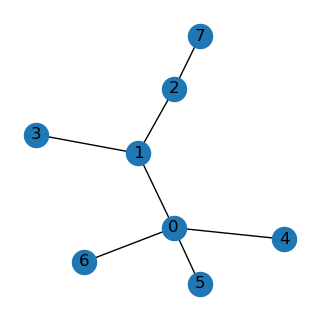

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the graph
plt.figure(figsize=(3,3))

nx.draw(G, with_labels=True)

plt.show()

In [6]:
# Print graph details
print(pyg_graph)
print('---')
print(pyg_graph.x)
print('---')
print(pyg_graph.edge_index)
print('---')
print(pyg_graph.edge_attrs)

Data(x=[8, 3], edge_index=[2, 14], edge_attrs=[14, 6])
---
tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]])
---
tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 4, 5, 6, 7],
        [1, 4, 5, 6, 0, 2, 3, 1, 7, 1, 0, 0, 0, 2]])
---
<bound method BaseData.edge_attrs of Data(x=[8, 3], edge_index=[2, 14], edge_attrs=[14, 6])>


In [7]:
from torch_geometric.nn import GCNConv

# Set up GCN layer
conv1 = GCNConv(3, 3)
# Ready data for GCN
x = pyg_graph.x.float()
edge_index = pyg_graph.edge_index
edge_attrs = pyg_graph.edge_attrs

In [8]:
# Pass data through GCN layer
out = conv1(x, edge_index)
print(out)


tensor([[-0.2757,  0.5450, -0.7764],
        [-0.4016, -0.9790, -0.8574],
        [-0.3111, -0.1622, -0.7048],
        [-0.3109, -0.7500, -0.6594],
        [-0.1559,  0.2129, -0.4587],
        [-0.1559,  0.2129, -0.4587],
        [-0.1559,  0.2129, -0.4587],
        [-0.3407,  0.0839, -0.6749]], grad_fn=<AddBackward0>)


In [9]:
import torch.nn.functional as F

# Pass through ReLU
out = F.relu(out)
print(out)

tensor([[0.0000, 0.5450, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.2129, 0.0000],
        [0.0000, 0.2129, 0.0000],
        [0.0000, 0.2129, 0.0000],
        [0.0000, 0.0839, 0.0000]], grad_fn=<ReluBackward0>)


In [10]:
import torch.nn as nn

BN = nn.BatchNorm1d(3)

In [11]:
#  Pass through batch normalisation
out = BN(out)
print(out)

tensor([[ 0.0000,  2.2349,  0.0000],
        [ 0.0000, -0.9162,  0.0000],
        [ 0.0000, -0.9162,  0.0000],
        [ 0.0000, -0.9162,  0.0000],
        [ 0.0000,  0.3151,  0.0000],
        [ 0.0000,  0.3151,  0.0000],
        [ 0.0000,  0.3151,  0.0000],
        [ 0.0000, -0.4314,  0.0000]], grad_fn=<NativeBatchNormBackward0>)


### GO Test

In [38]:
from Dataset import XASDataset
from icecream import ic

# Path raw directory containing the data
path = "./"
# Load and create the dataset
dataset = XASDataset(path)

In [39]:
# Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('------------')
# Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASDataset(319)
------------
Number of graphs: 319
Number of features: 10
Number of classes: 63482
------------
Data(x=[30, 10], edge_index=[2, 76], y=[200], edge_attrs=[76, 4], idx=[1], smiles='[c:0]12[c:4]3[c:8]4[c:10]5[cH:11][cH:14][c:15]6[c:13]4[c:17]4[c:19]([cH:18][cH:16]6)[cH:20][c:22]([OH:25])[c:23]([c:21]14)[CH2:24][CH:1]1[C:2]2([CH:3]=[CH:5][C:6]32[CH:7]([CH:9]5[C:12](=[O:26])[OH:27])[O:29]2)[O:28]1')
------------
Number of nodes: 30
Number of edges: 76
Average node degree: 2.53
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [40]:
train_dataset = dataset[0:252]
val_dataset = dataset[252:280]
test_dataset = dataset[280:]

In [41]:
from torch_geometric.loader import DataLoader

test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)

In [42]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.graph_pred_linear = nn.Linear(10, 200)        

    def forward(self, batched_data):
        
        x = batched_data.x.float()

        h_list = [x]

        out = self.graph_pred_linear(x)

        return out


In [43]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)

model

MLP(
  (graph_pred_linear): Linear(in_features=10, out_features=200, bias=True)
)

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)


In [47]:
def train(epoch):
    model.train()
    loss_all = 0
    
    for batch in train_loader:

        batch = batch.to(device)

        optimizer.zero_grad()

        pred = model(batch)
        batch_size = batch.y.shape[0] // 200
        ic(batch.y.shape)
        batch.y = batch.y.view(batch_size, 200)
        ic(pred.shape)
        ic(batch.y.shape)
        loss = nn.MSELoss()(pred.double(), batch.y.double())

        loss.backward()

        loss_all += loss.item() * batch.num_graphs
        optimizer.step()

    return loss_all / len(train_loader.dataset)

In [48]:
best_val_error = None
train_losses = []
val_losses = []

for epoch in range(0, 300):

    loss = train(epoch)

    val_error = test(val_loader)
    scheduler.step(val_error)
    # scheduler.step(epoch)
    train_losses.append(loss)
    val_losses.append(val_error)

    current_lr = optimizer.param_groups[0]["lr"]

    if best_val_error is None or val_error <= best_val_error:

        best_val_error = val_error

    if epoch % 25 == 0:
        print(f"Epoch: {epoch:03d}, LR: {current_lr:7f}, TrainLoss: {loss:.7f}, ValLoss:{val_error:7f}, Best_ValLoss:{best_val_error:7f}")

ic| batch.y.shape: torch.Size([6000])
ic| pred.shape: torch.Size([894, 200])
ic| batch.y.shape: torch.Size([30, 200])
/home/a3782/anaconda3/envs/go_gnn/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([30, 200])) that is different to the input size (torch.Size([894, 200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (894) must match the size of tensor b (30) at non-singleton dimension 0